# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

%load_ext autoreload
%autoreload 2
%matplotlib inline

# Create simple dataset

In [2]:
num_samples = 200
noise = np.random.randn(num_samples)*2

w_true = -0.5
b_true = 1

x = np.linspace(-2, 2, num_samples)
y_true = x * w_true + b_true
y = y_true + noise

## Estimate optimal parameters from regression

In [3]:

w_reg = - ((x*y).mean() - x.mean() * y.mean())/((x).mean()**2 - (x**2).mean())
b_reg = y.mean() - w_reg * x.mean()

w_reg, b_reg

(-0.56342302454439819, 1.0232621242924356)

## Plot fitted line

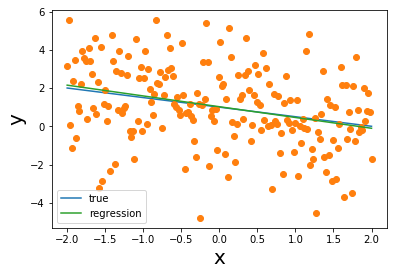

In [4]:
plt.plot(x, y_true, '-', label='true')
plt.plot(x, y, 'o')
plt.plot(x, x * w_reg + b_reg, '-', label='regression')
plt.xlabel("x", size=20)
plt.ylabel("y", size=20)
plt.legend()

## Plot posterior over w and b parameters values

Number of data points: 0


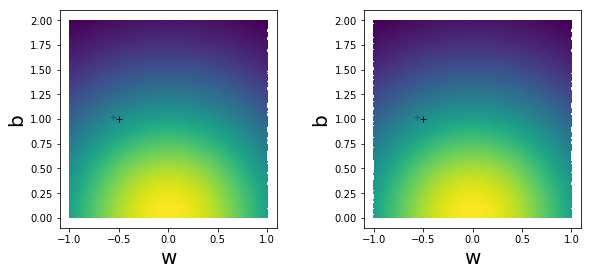

Number of data points: 1


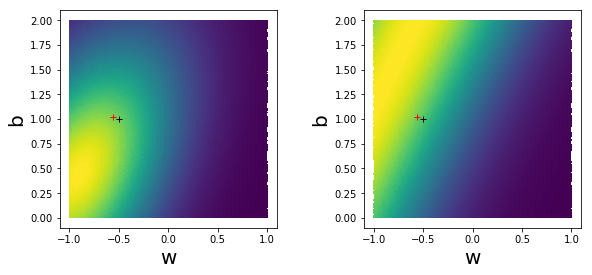

Number of data points: 2


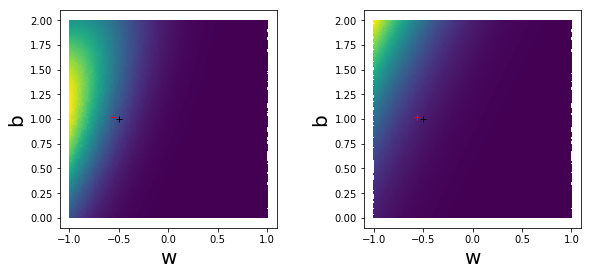

Number of data points: 5


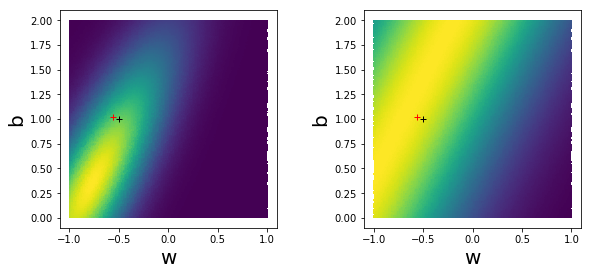

Number of data points: 10


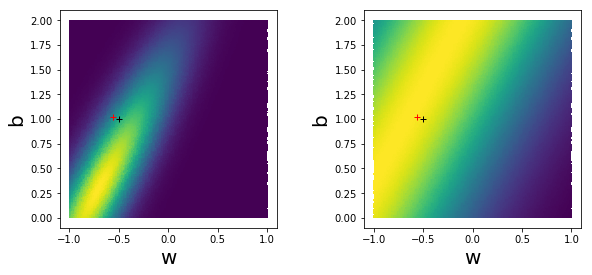

Number of data points: 20


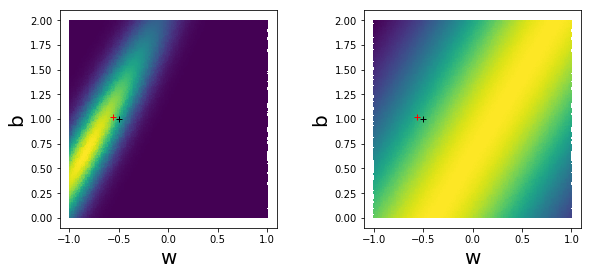

Number of data points: 50


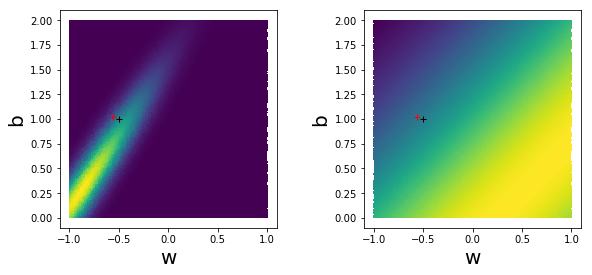

Number of data points: -1


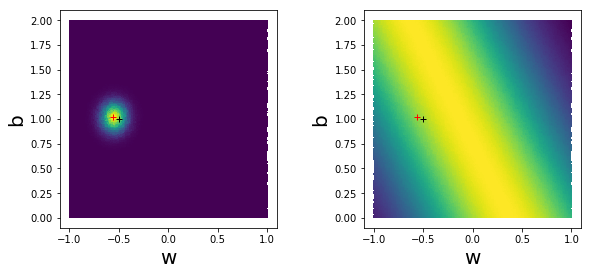

In [5]:
import itertools as itools

def posterior(Y, X, theta):
    ns = len(Y)
    sigma2 = 2
    w, b = theta
    prior = 1/np.sqrt(2*np.pi) * np.exp(-0.5*(w**2 + b**2))
    probs = np.concatenate([[prior], np.exp( -0.5/sigma2*( Y - w*X - b  )**2 )])        
    likelihood = np.prod(probs)
    return likelihood, probs[-1]

def posterior_map(Y, X):    
    w_scan = np.linspace(-1.0, 1.0, 100)
    b_scan = np.linspace(0.0, 2.0, 100)
    probs = []
    for w, b in itools.product(w_scan, b_scan):        
        probs.append((w, b, *posterior(Y, X, (w, b))))
    return np.array(probs)

num_points = [0, 1, 2, 5, 10, 20, 50, -1]
for nps in num_points:
    print("Number of data points:", nps)
    prob_map = posterior_map(y[:nps], x[:nps])

    plt.figure(figsize=(10, 4))
    ax = plt.subplot(121)
    plt.tripcolor(prob_map[:, 0], prob_map[:, 1], prob_map[:, 2])
    ax.axes.set_aspect('equal')
    plt.xlabel("w", size=20)
    plt.ylabel("b", size=20)
    plt.plot([w_true], [b_true], 'k+')
    plt.plot([w_reg], [b_reg], 'r+')

    ax = plt.subplot(122)
    plt.tripcolor(prob_map[:, 0], prob_map[:, 1], prob_map[:, 3])
    ax.axes.set_aspect('equal')
    plt.xlabel("w", size=20)
    plt.ylabel("b", size=20)
    plt.plot([w_true], [b_true], 'k+')
    plt.plot([w_reg], [b_reg], 'r+')
    plt.show()

## Mean field posterior map

In [6]:
# The posterior must be normalized and we have to know how to sample from it
# MLE finds the most probable estimate for parameters
# Bayesian approach shows potenatial distribution of parameters
# Having good prior we can converge faster to good solution

Number of data points: 0


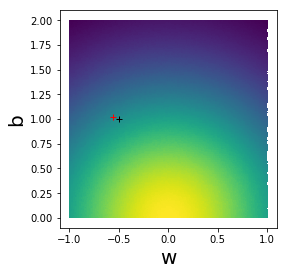

Number of data points: 1


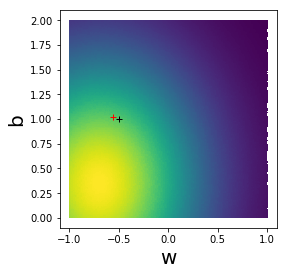

Number of data points: 2


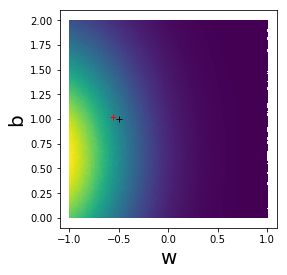

Number of data points: 5


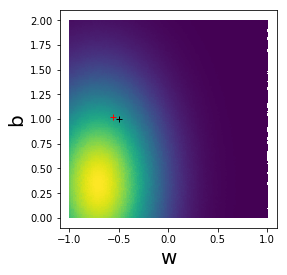

Number of data points: 10


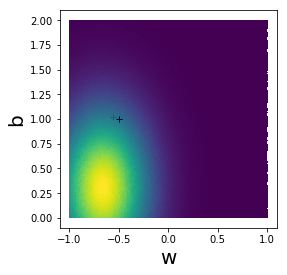

Number of data points: 20


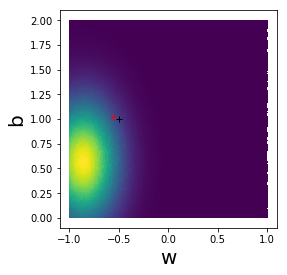

Number of data points: 50


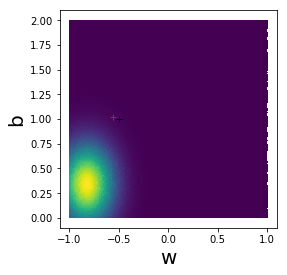

Number of data points: -1


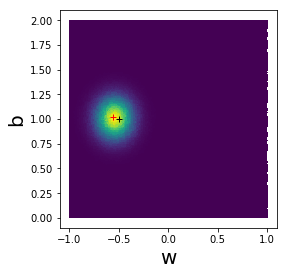

In [7]:
def mean_field_posterior(y, x, theta):
    w, b = theta
    sx = x.sum()
    sy = y.sum()
    sxy = (x*y).sum()
    sxx = (x*x).sum()
    s = 2  
    s1 = sum([1]*len(x))
    
    sw = 1/np.sqrt(sxx/s**2 + 1)
    sb = 1/np.sqrt(s1/s**2 + 1)
    # generated code by maxima
    mw = ((s**2+s1)*sxy-sx*sy)/(s**4+s**2*s1-sx**2+(s1+s**2)*sxx)
    mb = -((-sxx*sy)-s**2*sy+sx*sxy)/(s**4+s**2*s1-sx**2+(s1+s**2)*sxx)
    
    return 1/(2*np.pi*sw*sb)*np.exp(-0.5/(sw**2)*(w - mw)**2)*np.exp(-0.5/(sb**2)*(b - mb)**2)
    
def mean_field_posterior_map(Y, X):    
    w_scan = np.linspace(-1.0, 1.0, 100)
    b_scan = np.linspace(0.0, 2.0, 100)
    probs = []
    for w, b in itools.product(w_scan, b_scan):        
        probs.append((w, b, mean_field_posterior(Y, X, (w, b))))
    return np.array(probs)
    
num_points = [0, 1, 2, 5, 10, 20, 50, -1]
for nps in num_points:
    print("Number of data points:", nps)
    prob_map = mean_field_posterior_map(y[:nps], x[:nps])

    plt.figure(figsize=(10, 4))
    ax = plt.subplot(111)
    plt.tripcolor(prob_map[:, 0], prob_map[:, 1], prob_map[:, 2])
    ax.axes.set_aspect('equal')
    plt.xlabel("w", size=20)
    plt.ylabel("b", size=20)
    plt.plot([w_true], [b_true], 'k+')
    plt.plot([w_reg], [b_reg], 'r+')

    plt.show()

## Find optimal parameters using Variational Inference

In [8]:
# This show we need good prior or large number of data points
# Can we use MLE as a starting prior ???

In [9]:
# manually written gradient descent

def f(xi, wk, bk):
    return xi * wk + bk

Ni = 2000
Ns = 5
lr = 0.0002
sigma = 2

# Initial conditions
mw = 1 #w_reg
mb = 1 #b_reg
sw = 1
sb = 1

hist = []

for i in range(Ni):
    a = -1/(sigma**2 * Ns)
    eps_w = np.random.randn(Ns)
    eps_b = np.random.randn(Ns)
    
    grad_mw = 0
    grad_mb = 0
    grad_sw = 0
    grad_sb = 0

    for k in range(Ns):
        wk = mw + eps_w[k] * sw
        bk = mb + eps_b[k] * sb

        Dki = y - f(x, wk, bk)

        grad_mw += np.sum(Dki * x)        
        grad_sw += np.sum(Dki * x) * eps_w[k]
        
        grad_mb += np.sum(Dki)
        grad_sb += np.sum(Dki) * eps_b[k]

    grad_mw = a * grad_mw + mw
    grad_sw = a * grad_sw + sw - 1/sw
    
    grad_mb = a * grad_mb + mb    
    grad_sb = a * grad_sb + sb - 1/sb
    
    mw = mw - lr * grad_mw
    mb = mb - lr * grad_mb
    sw = sw - lr * grad_sw
    sb = sb - lr * grad_sb

    hist.append([mw, mb, sw, sb, grad_mw, grad_mb, grad_sw, grad_sb])
    
    if i%200 == 0:
        print(f"i: {i} lr: {lr}\n\t mw: {mw} mb: {mb}\n\t sw: {sw} sb: {sb}")

i: 0 lr: 0.0002
	 mw: 0.9678365495841518 mb: 1.003393145279707
	 sw: 0.9723526983758424 sb: 0.9858687811461305
i: 200 lr: 0.0002
	 mw: -0.4434318385289693 mb: 1.0116760706785282
	 sw: 0.15089058546264625 sb: 0.17858309073326115
i: 400 lr: 0.0002
	 mw: -0.5545229226589801 mb: 1.0066191951545005
	 sw: 0.12483529999259155 sb: 0.13959132368953028
i: 600 lr: 0.0002
	 mw: -0.5482987801309696 mb: 1.0087866654090576
	 sw: 0.13398473387284218 sb: 0.14471195847446872
i: 800 lr: 0.0002
	 mw: -0.5527306571596992 mb: 0.999882025161833
	 sw: 0.12140191077631342 sb: 0.13420462887250073
i: 1000 lr: 0.0002
	 mw: -0.5496447422541053 mb: 1.0006514556731962
	 sw: 0.12723516775128704 sb: 0.13683795396496629
i: 1200 lr: 0.0002
	 mw: -0.556057459929125 mb: 0.9978998935314058
	 sw: 0.11567999354562596 sb: 0.13681936396294553
i: 1400 lr: 0.0002
	 mw: -0.5453584637043503 mb: 1.0028186018331875
	 sw: 0.12159947321412806 sb: 0.1381905324556051
i: 1600 lr: 0.0002
	 mw: -0.5642848034624686 mb: 0.9969099240713909
	 

In [10]:
hist = np.array(hist)
hist.shape

(2000, 8)

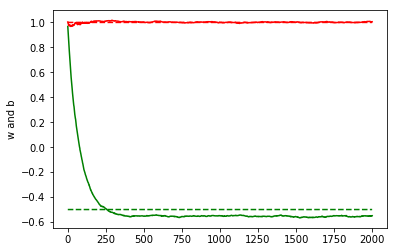

In [11]:
plt.plot(hist[:, 0], 'g')
plt.plot(np.ones(shape=[Ni])*w_true, "g--")
plt.ylabel("w and b")

plt.plot(hist[:, 1], 'r')
plt.plot(np.ones(shape=[Ni])*b_true, "r--")

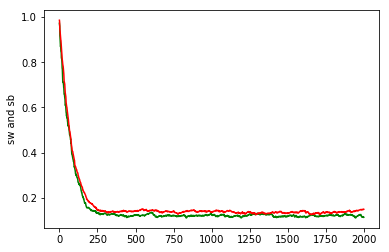

In [12]:
plt.plot(hist[:, 2], 'g')
plt.plot(hist[:, 3], 'r')
plt.ylabel("sw and sb")

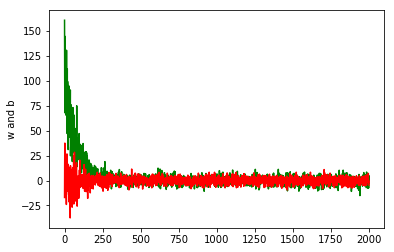

In [13]:
# gradients
plt.plot(hist[:, 4], 'g')
plt.plot(hist[:, 5], 'r')
plt.ylabel("w and b")

## Find optimal parameters using Variational Inference after reparametrization

Replace `sigma` with `sigma = exp(sigma_prime)`

In [14]:
def f(xi, wk, bk):
    return xi * wk + bk

Ni = 1500
Ns = 5
lr = 0.001
sigma = 2

# Initial conditions
mw = 1 # w_reg
mb = 1 # b_reg
pw = 1
pb = 1

hist = []
loss_hist = []

for i in range(Ni):
    a = -1/(sigma**2 * Ns)
    eps_w = np.random.randn(Ns)
    eps_b = np.random.randn(Ns)
    
    grad_mw = 0
    grad_mb = 0
    grad_pw = 0
    grad_pb = 0
    lh_loss = 0
    for k in range(Ns):
        wk = mw + eps_w[k] * np.exp(pw)
        bk = mb + eps_b[k] * np.exp(pb)

        Dki = y - f(x, wk, bk)

        grad_mw += np.sum(Dki * x)        
        grad_pw += np.sum(Dki * x) * eps_w[k] * np.exp(pw)
        
        grad_mb += np.sum(Dki)
        grad_pb += np.sum(Dki) * eps_b[k] * np.exp(pb)
        
        lh_loss += np.mean(Dki**2)

    grad_mw = a * grad_mw + mw
    grad_pw = a * grad_pw + np.exp(2*pw) - 1
    
    grad_mb = a * grad_mb + mb    
    grad_pb = a * grad_pb + np.exp(2*pb) - 1
    
    mw = mw - lr * grad_mw
    mb = mb - lr * grad_mb
    pw = pw - lr * grad_pw
    pb = pb - lr * grad_pb
        
    lh_loss *= a
    kl_loss = 0.5 * (mw**2 + mb**2 + np.exp(2*pw) + np.exp(2*pb)) - (pw + pb + 1) 
    
    hist.append([mw, mb, pw, pb, grad_mw, grad_mb, grad_pw, grad_pb])
    loss_hist.append([lh_loss, kl_loss, lh_loss - kl_loss])
    
    if i%200 == 0:
        print(f"i: {i} lr: {lr}\n\t mw: {mw} mb: {mb}\n\t pw: {np.exp(pw)} pb: {np.exp(pb)}")
        
hist = np.array(hist)
loss_hist = np.array(loss_hist)

i: 0 lr: 0.001
	 mw: 0.9907659915792772 mb: 1.0769838951437545
	 pw: 0.5175269246893444 pb: 1.5190944989137776
i: 200 lr: 0.001
	 mw: -0.5170544046450121 mb: 0.9685312736568304
	 pw: 0.20326039407034846 pb: 0.23773433929258161
i: 400 lr: 0.001
	 mw: -0.5361213287172963 mb: 1.0312806516396271
	 pw: 0.16061409140179086 pb: 0.1847429829016282
i: 600 lr: 0.001
	 mw: -0.5409709738767263 mb: 1.0095328663445566
	 pw: 0.1454856356993673 pb: 0.168460814610469
i: 800 lr: 0.001
	 mw: -0.5490055657418459 mb: 1.0128389932524213
	 pw: 0.13409634698038833 pb: 0.1577001012015579
i: 1000 lr: 0.001
	 mw: -0.565312493885943 mb: 1.0188727790094931
	 pw: 0.1277803373806561 pb: 0.1502143676262263
i: 1200 lr: 0.001
	 mw: -0.5473178503050591 mb: 1.0120728761181839
	 pw: 0.1243347829156801 pb: 0.14609473014058846
i: 1400 lr: 0.001
	 mw: -0.5588160232375702 mb: 0.9996477516817704
	 pw: 0.12224070565778788 pb: 0.14442365243259578


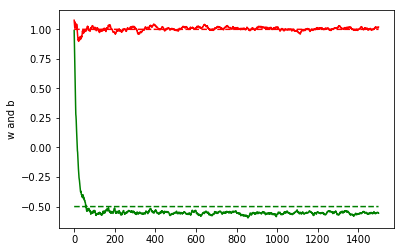

In [15]:
plt.plot(hist[:, 0], 'g')
plt.plot(np.ones(shape=[Ni])*w_true, "g--")

plt.plot(hist[:, 1], 'r')
plt.plot(np.ones(shape=[Ni])*b_true, "r--")

plt.ylabel("w and b")

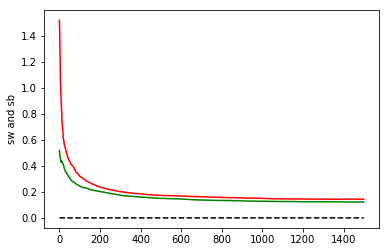

In [16]:
plt.plot(np.exp(hist[:, 2]), 'g')
plt.plot(np.exp(hist[:, 3]), 'r')
plt.plot(np.zeros(shape=[Ni]), 'k--')
plt.ylabel("sw and sb")

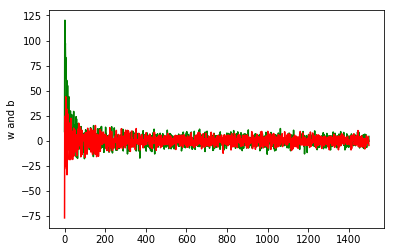

In [17]:
plt.plot(hist[:, 4], 'g')
plt.plot(hist[:, 5], 'r')
plt.ylabel("w and b")

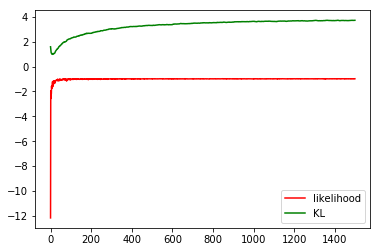

In [18]:
plt.plot(loss_hist[:, 0], "r", label="likelihood")
plt.plot(loss_hist[:, 1], "g", label="KL")
# plt.plot(loss_hist[:, 2], "k", label="total")
plt.legend()

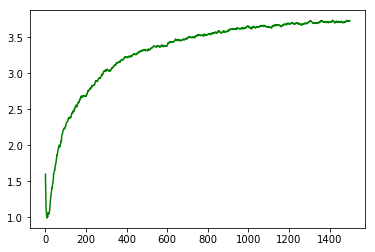

In [19]:
plt.plot(loss_hist[:, 1], "g", label="KL")

## Plot posteriors after convergence

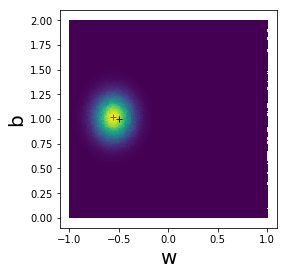

In [21]:
def sgd_mean_field_posterior(theta):
    w, b = theta    
    sw = np.exp(pw)
    sb = np.exp(pb)    
    return 1/(2*np.pi*sw*sb) \
            * np.exp(-0.5/(sw**2)*(w - mw)**2)\
            * np.exp(-0.5/(sb**2)*(b - mb)**2)
    
def sgd_mean_field_posterior_map():    
    w_scan = np.linspace(-1.0, 1.0, 100)
    b_scan = np.linspace(0.0, 2.0, 100)
    probs = []
    for w, b in itools.product(w_scan, b_scan):        
        probs.append((w, b, sgd_mean_field_posterior((w, b))))
    return np.array(probs)


prob_map = sgd_mean_field_posterior_map()
plt.figure(figsize=(10, 4))
ax = plt.subplot(111)
plt.tripcolor(prob_map[:, 0], prob_map[:, 1], prob_map[:, 2])
ax.axes.set_aspect('equal')
plt.xlabel("w", size=20)
plt.ylabel("b", size=20)
plt.plot([w_true], [b_true], 'k+')
plt.plot([w_reg], [b_reg], 'r+')
plt.show()

# Sampling from posteriors

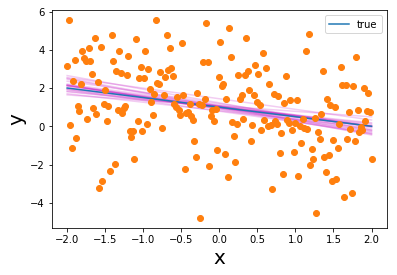

In [22]:
def sample_wb():
    wk = mw + np.random.randn() * np.exp(pw)
    bk = mb + np.random.randn() * np.exp(pb)
    return wk, bk

for s in range(20):
    wk, bk = sample_wb()
    fs = f(x, wk, bk)
    plt.plot(x, fs, 'm-', alpha=0.2)

plt.plot(x, y_true, '-', label='true')
plt.plot(x, y, 'o')
plt.xlabel("x", size=20)
plt.ylabel("y", size=20)
plt.legend()